# Analyze model results: example shown is the final model

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import colorsys

#plot parameters 
import matplotlib
import matplotlib.patheffects as path_effects

#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

import sys
from sklearn import metrics

colors = ['#F6A5AE', '#228833', '#4577AA','#67CCED', '#AA3377']


In [2]:
name = 'Final'
file_path = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/'
results = pd.read_csv(file_path+name+'_preds.csv', index_col = 0)
test = pd.read_csv(file_path+name+'_test.csv', index_col = 0)


## Performance diagram to determine cutoff threshold

In [3]:
pods = []
srs = []
csi = []

for r in range(5):

    pods_region = []
    srs_region = []
    csi_region = []
    for i in np.arange(0,1,.05):
        predict = np.where(results[str(r)]>=i,1,0)
        TP = len(np.where((predict==1) & (test[str(r)]==1))[0])
        FP = len(np.where((predict==1) & (test[str(r)]==0))[0])
        FN = len(np.where((predict==0) & (test[str(r)]==1))[0])
        TN = len(np.where((predict==0) & (test[str(r)]==0))[0])
        pods_region.append((TP)/(FN+TP))
        srs_region.append(TP/(TP+FP))
        csi_region.append((TP)/(FP+FN+TP))

    pods.append(np.array(pods_region))
    srs.append(np.array(srs_region))
    csi.append(np.array(csi_region))

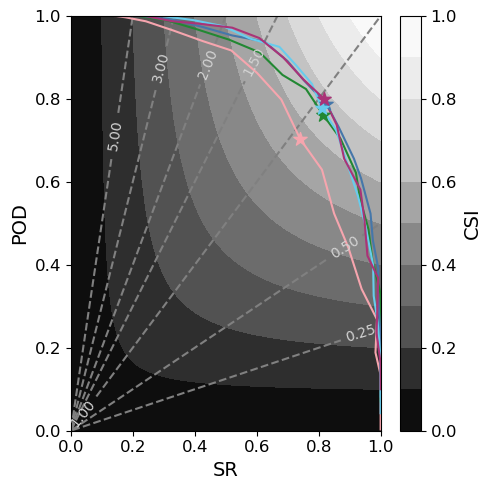

In [4]:
id_45 = int(np.where(np.arange(0,1,.05) == .45)[0])
#import some helper functions for our other directory.

sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
for r in range(5):
    ax.plot(np.asarray(srs[r]),np.asarray(pods[r]),color=colors[r])
    ax.scatter(np.asarray(srs[r])[id_45], np.asarray(pods[r])[id_45], marker = '*', s = 100, color = colors[r], zorder = 20)

# plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/performance_diagram_regional.png', dpi = 300, transparent = True, bbox_inches = 'tight')

plt.tight_layout();

## Calculate AUC_PR and Accuracy per region 

In [5]:
auc_pr_region = []
accuracy_region = []
for r in range(5):
    precision, recall, thresholds = metrics.precision_recall_curve(np.array(test[str(r)]),np.array(results[str(r)]), pos_label = 1)
    auc_pr = np.round(metrics.auc(recall, precision),2)
    auc_pr_region.append(auc_pr)
    
    predict = np.where(results[str(r)]>=.45,1,0)
    TP = len(np.where((predict==1) & (test[str(r)]==1))[0])
    FP = len(np.where((predict==1) & (test[str(r)]==0))[0])
    FN = len(np.where((predict==0) & (test[str(r)]==1))[0])
    TN = len(np.where((predict==0) & (test[str(r)]==0))[0])
    accuracy_region.append(np.round((TP+TN)/(FP+FN+TP+TN),2))


In [6]:
auc_pr_region

[0.82, 0.88, 0.9, 0.89, 0.89]

In [7]:
accuracy_region

[0.92, 0.93, 0.94, 0.93, 0.94]

## Other assessments

In [8]:
x_regions = []
y_regions = []
area_regions = []
for r in range(5):
    area = 0
    y = []
    x = []
    for i in np.arange(0,1.05,.05):
        predict = np.where(results[str(r)]>=i,1,0)
        TP = len(np.where((predict==1) & (test[str(r)]==1))[0])
        FP = len(np.where((predict==1) & (test[str(r)]==0))[0])
        FN = len(np.where((predict==0) & (test[str(r)]==1))[0])
        if TP > 0:
            prec = TP/(TP+FP)
            rec = TP/(TP+FN)
            y.append(prec)
            x.append(rec)
            area = area + prec*.05
    area_regions.append(area)
    x_regions.append(np.array(x))
    y_regions.append(np.array(y))

Text(0, 0.5, 'Precision')

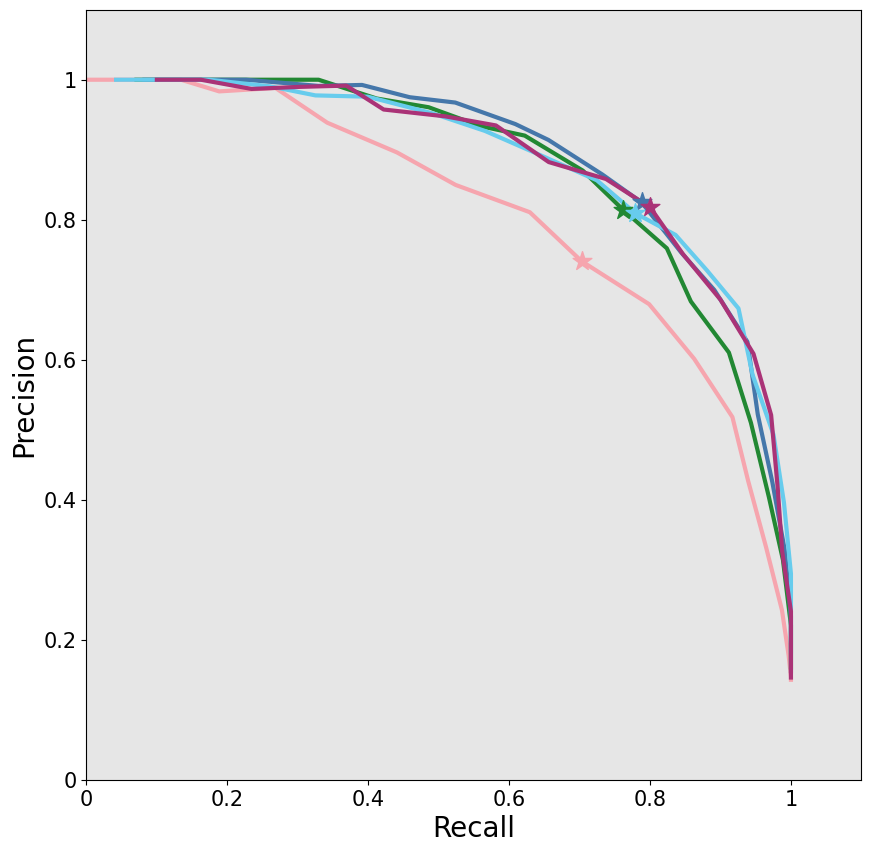

In [9]:
id_45 = int(np.where(np.arange(0,1.05,.05) == .45)[0])

fig,ax = plt.subplots(1,1,figsize=(10, 10))
for r in range(5):
    ax.plot(x_regions[r],y_regions[r], linewidth = 3, color = colors[r])
#     ax.scatter(x_regions[r],y_regions[r], color = colors[r])
    ax.scatter(x_regions[r][id_45],y_regions[r][id_45],marker = '*', s = 200, color = colors[r], zorder = 20)
#     ax.scatter(x_regions[r][id_45+1],y_regions[r][id_45+1], s = 100, color = colors[r])
#     ax.scatter(x_regions[r][id_45-1],y_regions[r][id_45-1], s = 100, color = colors[r])

# ax.axhline(y = .15, xmin = 0 ,xmax = 1, linewidth = 4, linestyle = '--', color = 'black')
ax.set_xticks(np.arange(0,1.2,.2))
ax.set_xlim(0,1.1)
ax.set_ylim(0,1.1)
ax.set_xticklabels(labels = [0,.2,.4,.6,.8,1], fontsize = 15)
ax.set_yticks(np.arange(0,1.2,.2))
ax.set_yticklabels(labels = [0,.2,.4,.6,.8,1], fontsize = 15);
ax.set_xlabel('Recall', fontsize = 20)
ax.set_ylabel('Precision', fontsize = 20)
# ax.fill_between(x_regions[r], y1 = y_regions[r], y2 = 0, alpha = .5)
# plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/auc_pr.png', dpi = 300, transparent = True, bbox_inches = 'tight')


In [10]:
accuracy = []
csi = []
for r in range(5):

    accuracy_region = []
    csi_region = []
    for i in np.arange(0,1.05,.05):
        predict = np.where(results[str(r)]>=i,1,0)
        TP = len(np.where((predict==1) & (test[str(r)]==1))[0])
        FP = len(np.where((predict==1) & (test[str(r)]==0))[0])
        FN = len(np.where((predict==0) & (test[str(r)]==1))[0])
        TN = len(np.where((predict==0) & (test[str(r)]==0))[0])
        accuracy_region.append((TP+TN)/(FP+FN+TP+TN))
        csi_region.append((TP)/(FP+FN+TP))

    accuracy.append(np.array(accuracy_region))
    csi.append(np.array(csi_region))

Text(0, 0.5, 'CSI')

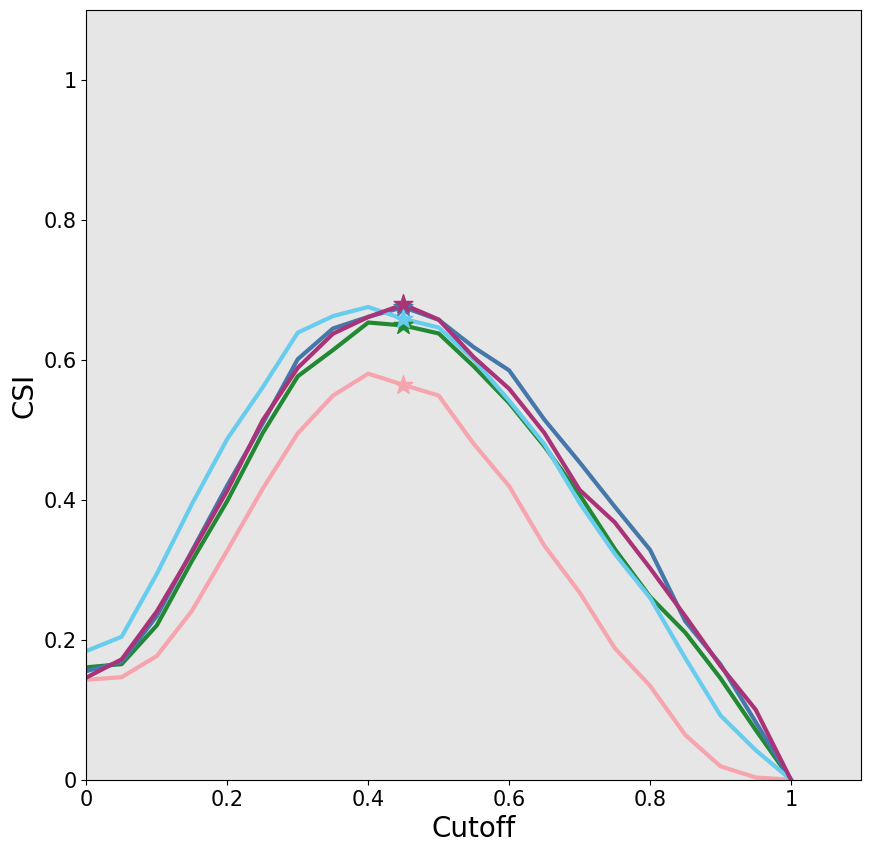

In [11]:
id_45 = int(np.where(np.arange(0,1.05,.05) == .45)[0])

fig,ax = plt.subplots(1,1,figsize=(10, 10))
for r in range(5):
    ax.plot(np.arange(0,1.05,.05),csi[r], linewidth = 3, color = colors[r])
#     ax.scatter(x_regions[r],y_regions[r], color = colors[r])
    ax.scatter(np.arange(0,1.05,.05)[id_45],csi[r][id_45], marker = '*', s = 200, color = colors[r], zorder = 20)
#     ax.scatter(x_regions[r][id_45+1],y_regions[r][id_45+1], s = 100, color = colors[r])
#     ax.scatter(x_regions[r][id_45-1],y_regions[r][id_45-1], s = 100, color = colors[r])

# ax.axhline(y = .15, xmin = 0 ,xmax = 1, linewidth = 4, linestyle = '--', color = 'black')
ax.set_xticks(np.arange(0,1.2,.2))
ax.set_xlim(0,1.1)
ax.set_ylim(0,1.1)
ax.set_xticklabels(labels = [0,.2,.4,.6,.8,1], fontsize = 15)
ax.set_yticks(np.arange(0,1.2,.2))
ax.set_yticklabels(labels = [0,.2,.4,.6,.8,1], fontsize = 15);
ax.set_xlabel('Cutoff', fontsize = 20)
ax.set_ylabel('CSI', fontsize = 20)
# ax.fill_between(x_regions[r], y1 = y_regions[r], y2 = 0, alpha = .5)
# plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/auc_pr.png', dpi = 300, transparent = True, bbox_inches = 'tight')


Text(0, 0.5, 'Accuracy')

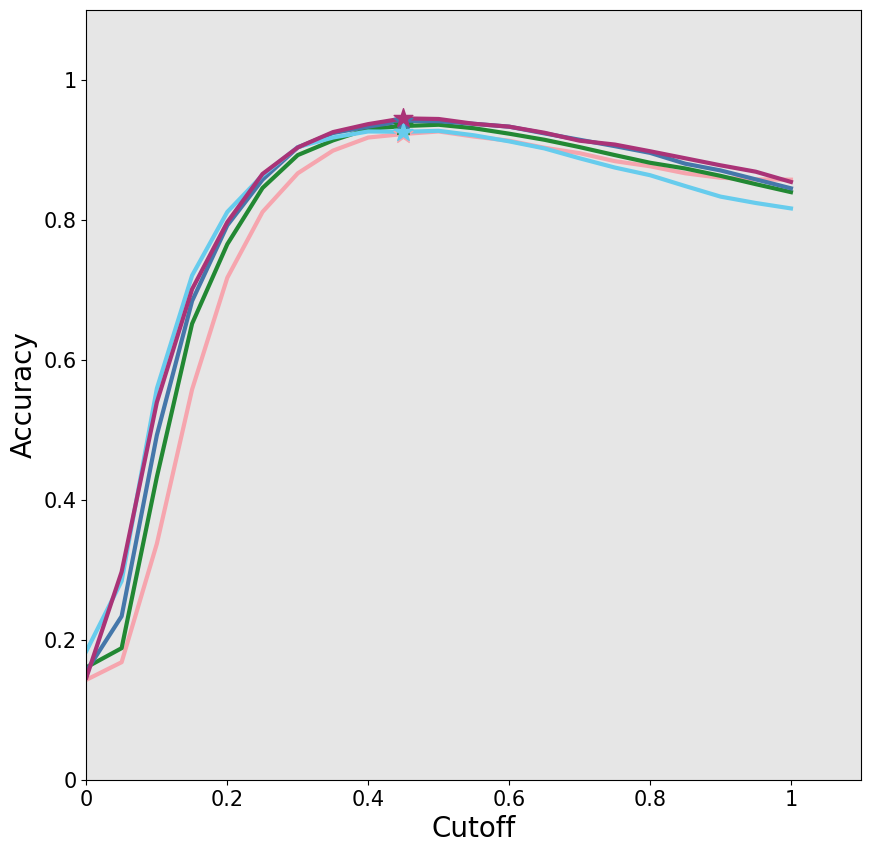

In [12]:
id_45 = int(np.where(np.arange(0,1.05,.05) == .45)[0])

fig,ax = plt.subplots(1,1,figsize=(10, 10))
for r in range(5):
    ax.plot(np.arange(0,1.05,.05),accuracy[r], linewidth = 3, color = colors[r])
#     ax.scatter(x_regions[r],y_regions[r], color = colors[r])
    ax.scatter(np.arange(0,1.05,.05)[id_45],accuracy[r][id_45], marker = '*', s = 200, color = colors[r], zorder = 20)
#     ax.scatter(x_regions[r][id_45+1],y_regions[r][id_45+1], s = 100, color = colors[r])
#     ax.scatter(x_regions[r][id_45-1],y_regions[r][id_45-1], s = 100, color = colors[r])

# ax.axhline(y = .15, xmin = 0 ,xmax = 1, linewidth = 4, linestyle = '--', color = 'black')
ax.set_xticks(np.arange(0,1.2,.2))
ax.set_xlim(0,1.1)
ax.set_ylim(0,1.1)
ax.set_xticklabels(labels = [0,.2,.4,.6,.8,1], fontsize = 15)
ax.set_yticks(np.arange(0,1.2,.2))
ax.set_yticklabels(labels = [0,.2,.4,.6,.8,1], fontsize = 15);
ax.set_xlabel('Cutoff', fontsize = 20)
ax.set_ylabel('Accuracy', fontsize = 20)
# ax.fill_between(x_regions[r], y1 = y_regions[r], y2 = 0, alpha = .5)
# plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/accuracy.png', dpi = 300, transparent = True, bbox_inches = 'tight')


## Check out one model training

In [17]:
name = 'Final'
file_path = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/'
results = pd.read_csv(file_path+name+'_preds.csv', index_col = 0)
test = pd.read_csv(file_path+name+'_test.csv', index_col = 0)
history = pd.read_csv(file_path+name+'_history.csv')
variable_list = ['V','IWV']

In [18]:
testing_parameters_select = (2, 100, 3, 100, 1e-6, 100)

In [19]:
precision, recall, thresholds = metrics.precision_recall_curve(np.array(test).ravel(),np.array(results).ravel(), pos_label = 1)
auc_pr = np.round(metrics.auc(recall, precision),3)
print('AUC_PR: ')
auc_pr

AUC_PR: 


0.877

In [20]:
predict = np.array(np.where(results>=.45,1,0))
cont_table = get_contingency_table(np.array(test),predict)

np.round(get_acc(cont_table))


93.0

In [21]:
region_labels = ['1','2','3', '4','5']
regions = np.arange(5)
def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

colors_rgb = [matplotlib.colors.ColorConverter.to_rgb(colors[r]) for r in regions]
color_maps_list = []
for r in regions:
    color_maps_list.append([scale_lightness(colors_rgb[r], scale) for scale in [ .3, .6, .9, 1.2]])

color_maps = [matplotlib.colors.ListedColormap(color_maps_list[r], name='Region_'+region_labels[r]) for r in regions]

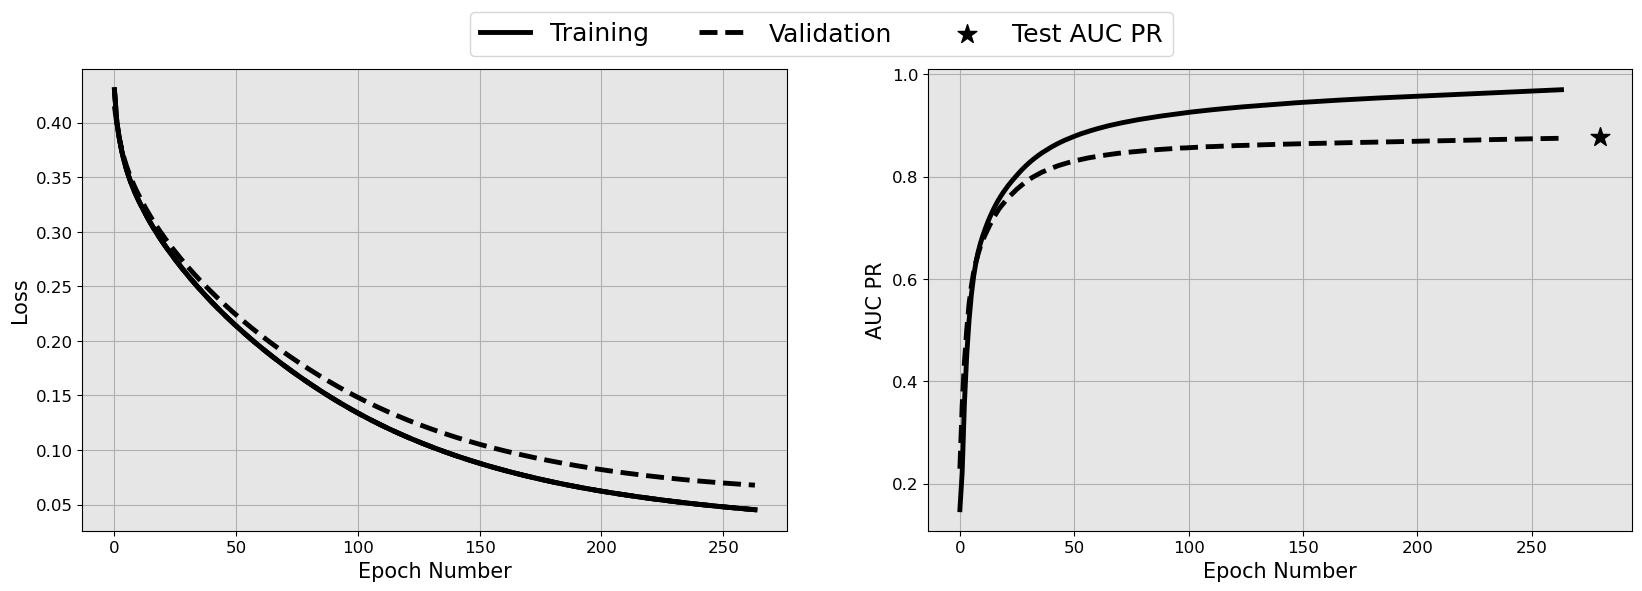

In [22]:


fig,axes = plt.subplots(1,2,figsize=(20, 6))
axes[0].set_xlabel('Epoch Number', size = 15)
axes[0].set_ylabel('Loss', size = 15)

axes[0].grid()
axes[1].set_xlabel('Epoch Number', size = 15)
axes[1].set_ylabel('AUC PR', size = 15)
axes[1].grid()

lw = 3.5
axes[0].plot(history['loss'],linestyle='-', linewidth = lw, label = 'Training', color = 'black')
axes[0].plot(history['loss'],linestyle = '--', linewidth = lw, label = 'Validation', color = 'black')

axes[0].plot(history['loss'],linestyle='-',linewidth = lw, color = 'black')
axes[0].plot(history['val_loss'],linestyle = '--', linewidth = lw, color = 'black')

axes[1].plot(history['auc'],linestyle='-', linewidth = lw, color = 'black')
axes[1].plot(history['val_auc'],linestyle = '--', linewidth = lw, color = 'black')
axes[1].scatter(280, auc_pr,  s = 200,marker = '*',label ='Test AUC PR', color = 'black')

fig.legend(loc = 'upper center',ncols = 7, fontsize = 18)

# plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/training_loss.png', dpi = 300, transparent = True, bbox_inches = 'tight')


## Precip for incorrect predictions

In [24]:
r = 0
cutoff = .45
result_preds =  np.array(np.where(results[str(r)]>=cutoff,1,0))
region_q85 = [1.915272960952153, 2.6067111170982145, 2.7608478750915273, 2.355092379269196, 4.3854167970376805]

tp_times = pd.to_datetime(test.index[np.where((result_preds == 1) & (test[str(r)] ==1))[0]])
tn_times = pd.to_datetime(test.index[np.where((result_preds == 0) & (test[str(r)] ==0))[0]])
fp_times = pd.to_datetime(test.index[np.where((result_preds == 1) & (test[str(r)] ==0))[0]])
fn_times = pd.to_datetime(test.index[np.where((result_preds == 0) & (test[str(r)] ==1))[0]])

region_st = ['90','12','34','56','78']
precip = pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/precip_Y_region'+region_st[r]+'.csv')
tp_precip = precip[pd.to_datetime(precip.time).isin(tp_times)]['precsn']
tn_precip = precip[pd.to_datetime(precip.time).isin(tn_times)]['precsn']
fp_precip = precip[pd.to_datetime(precip.time).isin(fp_times)]['precsn']
fn_precip = precip[pd.to_datetime(precip.time).isin(fn_times)]['precsn']

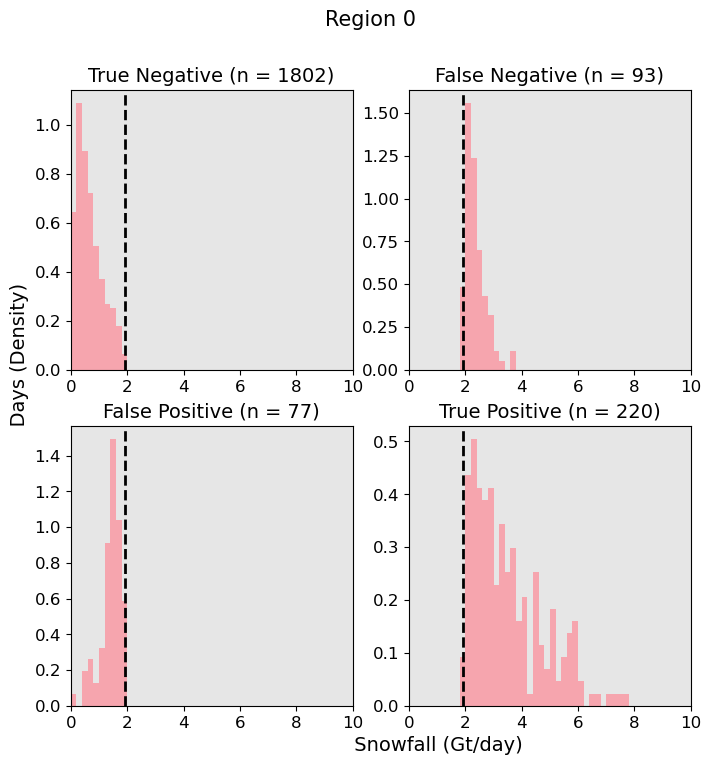

In [25]:
fig,axes = plt.subplots(2,2,figsize=(8, 8))
axes = axes.flatten()
fig.suptitle('Region '+str(r), size = 15)


axes[0].hist(tn_precip, bins = np.arange(0,8, .2),color = colors[r], density = True)
axes[0].set_title('True Negative (n = '+str(len(tn_times)) +')')
axes[0].set_xlim([0,10])
axes[0].axvline(region_q85[r], linestyle = '--', linewidth = 2, color = 'black')

axes[1].hist(fn_precip, bins = np.arange(0,8, .2),color = colors[r], density = True)
axes[1].set_title('False Negative (n = '+str(len(fn_times)) +')')
axes[1].set_xlim([0,10])
axes[1].axvline(region_q85[r], linestyle = '--', linewidth = 2, color = 'black')


axes[2].hist(fp_precip, bins = np.arange(0,8, .2),color = colors[r], density = True)
axes[2].set_xlim([0,10])
axes[2].set_title('False Positive (n = '+str(len(fp_times))+')')
axes[2].axvline(region_q85[r], linestyle = '--', linewidth = 2, color = 'black')
axes[2].set_xlabel('                                                                          Snowfall (Gt/day)')
axes[2].set_ylabel('                                                                     Days (Density)')


axes[3].hist(tp_precip, bins = np.arange(0,8, .2),color = colors[r], density = True)
axes[3].set_xlim([0,10])
axes[3].set_title('True Positive (n = '+str(len(tp_times))+')')
axes[3].axvline(region_q85[r], linestyle = '--', linewidth = 2, color = 'black')


## Confidence

In [26]:
regions = 0
true = pd.read_csv(file_path+name+'_test.csv', index_col = 0)

preds = np.array(np.where(results[str(r)]>=cutoff,1,0)).ravel().flatten()
TS_preds = preds[preds==1].flatten()
noTS_preds = preds[preds==0].flatten() 
TS_results = np.array(results[str(r)]).ravel()[preds==1].flatten() 
noTS_results = np.array(results[str(r)]).ravel()[preds==0].flatten()
TS_val = np.array(true[str(r)]).ravel()[preds==1].flatten()
noTS_val = np.array(true[str(r)]).ravel()[preds==0].flatten() 


In [27]:

buckets = np.arange(0,1.02,.02)

TS_n_data=[]
TS_n_true = []
noTS_n_data=[]
noTS_n_true = []

for r in range(5):
    preds_value_np = np.array(results[str(r)])
    preds_np =  np.array(np.where(results[str(r)]>=cutoff,1,0))
    results_np = np.array(test[str(r)])

    TS_preds_value = preds_value_np[preds_np==1]
    noTS_preds_value = preds_value_np[preds_np==0]

    TS_preds = preds_np[preds_np==1]
    noTS_preds = preds_np[preds_np==0] 

    TS_results = results_np[preds_np==1]
    noTS_results = results_np[preds_np==0]


    TS_num_data=[]
    TS_num_true = []
    noTS_num_data=[]
    noTS_num_true = []
    for i in range(len(buckets)-1):
        TS_num_data.append(len(TS_preds[(TS_preds_value>=buckets[i]) & (TS_preds_value<buckets[i+1])]))
        TS_num_true.append(TS_results[(TS_preds_value>=buckets[i]) & (TS_preds_value<buckets[i+1])].sum())
        
        noTS_num_true.append(np.where(noTS_results[(noTS_preds_value>=buckets[i]) & (noTS_preds_value<buckets[i+1])]==0,1,0).sum())
        noTS_num_data.append(len(noTS_preds[(noTS_preds_value>=buckets[i]) & (noTS_preds_value<buckets[i+1])]))

    TS_n_data.append(np.array(TS_num_data))
    noTS_n_data.append(np.array(noTS_num_data))
    TS_n_true.append(np.array(TS_num_true))
    noTS_n_true.append(np.array(noTS_num_true))

/tmp/ipykernel_311280/1486679700.py:6: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[0])/np.cumsum(TS_n_data[0]), lw = lw, color = colors[0],label = str(1))
/tmp/ipykernel_311280/1486679700.py:7: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[1])/np.cumsum(TS_n_data[1]), lw = lw, color = colors[1],label = str(2))
/tmp/ipykernel_311280/1486679700.py:8: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[2])/np.cumsum(TS_n_data[2]), lw = lw, color = colors[2],label = str(3))
/tmp/ipykernel_311280/1486679700.py:9: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[3])/np.cumsum(TS_n_data[3]), lw = lw, color = colors[3],label = str(4))
/tmp/ipykernel_311280/1486679700.py:10: RuntimeWarning: invalid value encountered in divide
  ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[4])/np.cumsum(TS_n_da

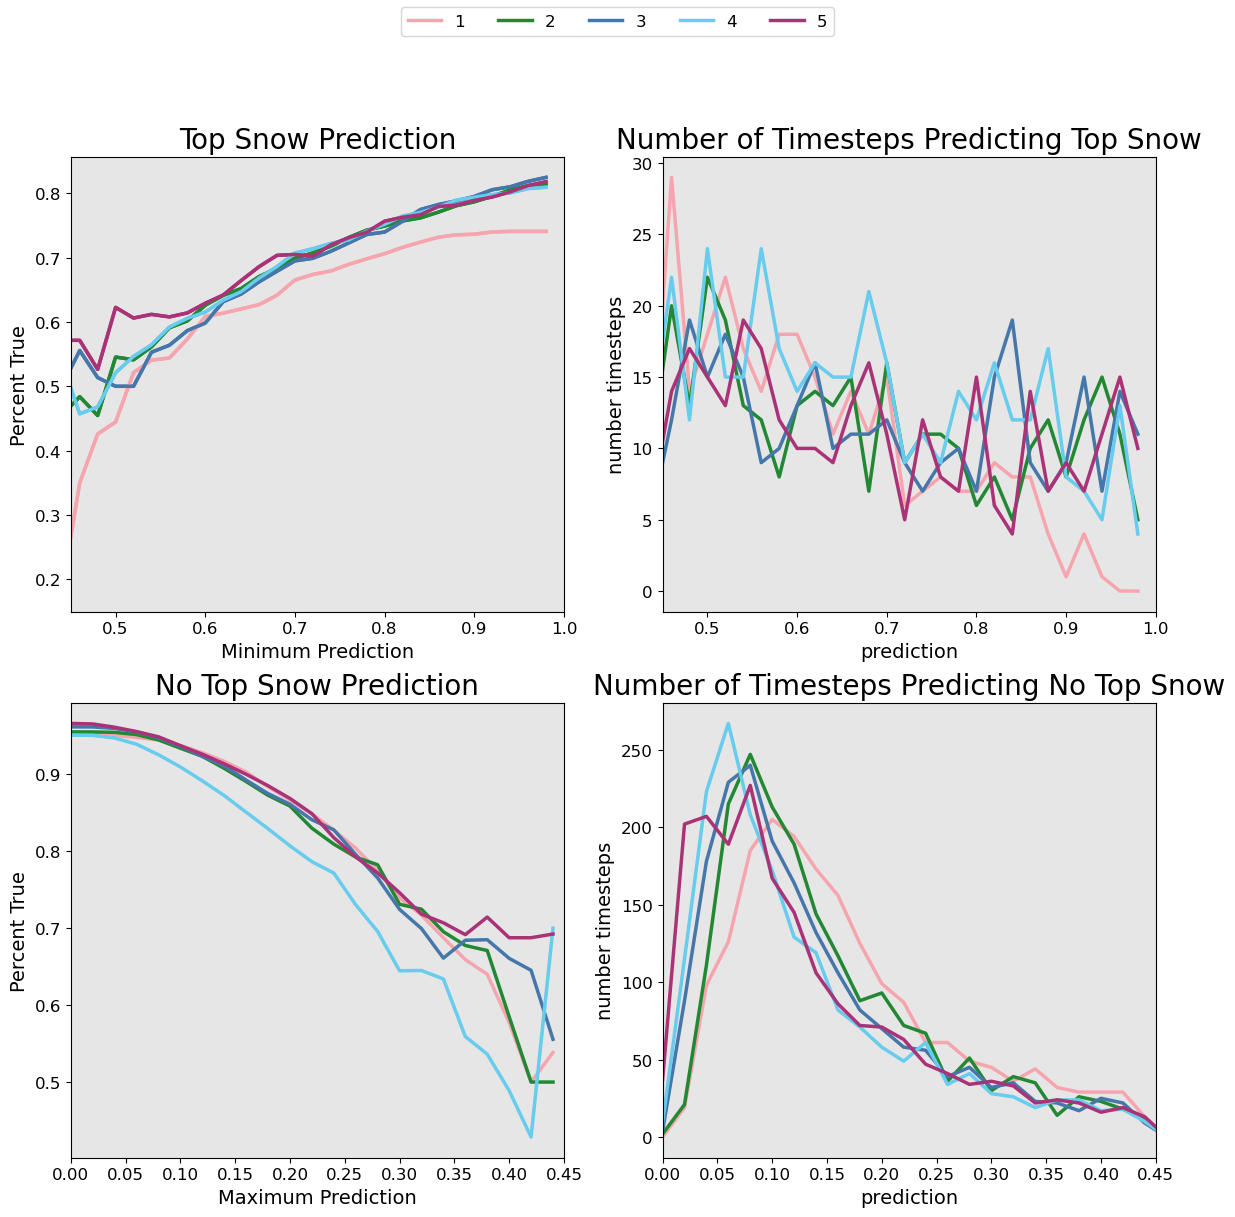

In [28]:
buckets = np.arange(0,1.02,.02)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14,13))
ax = axes.flatten()

lw = 2.5
ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[0])/np.cumsum(TS_n_data[0]), lw = lw, color = colors[0],label = str(1))
ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[1])/np.cumsum(TS_n_data[1]), lw = lw, color = colors[1],label = str(2))
ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[2])/np.cumsum(TS_n_data[2]), lw = lw, color = colors[2],label = str(3))
ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[3])/np.cumsum(TS_n_data[3]), lw = lw, color = colors[3],label = str(4))
ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[4])/np.cumsum(TS_n_data[4]), lw = lw, color = colors[4],label = str(5))

for r in range(5):
    ax[0].plot(buckets[:-1], np.cumsum(TS_n_true[r])/np.cumsum(TS_n_data[r]), lw = lw, color = colors[r])
    ax[1].plot(buckets[:-1], TS_n_data[r], lw = lw, color = colors[r])
    ax[2].plot(buckets[:-1], np.cumsum(noTS_n_true[r][::-1])[::-1] /np.cumsum(noTS_n_data[r][::-1])[::-1] , lw = lw, color = colors[r])
    ax[3].plot(buckets[:-1], noTS_n_data[r], lw = lw, color = colors[r])

ax[0].set_xlim((cutoff,1))
ax[1].set_xlim((cutoff,1))

ax[2].set_xlim((0,cutoff))
ax[3].set_xlim((0,cutoff))


ax[0].set_xlabel('Minimum Prediction')
ax[0].set_ylabel('Percent True')
ax[0].set_title('Top Snow Prediction', size = 20)

ax[1].set_xlabel('prediction')
ax[1].set_ylabel('number timesteps')
ax[1].set_title('Number of Timesteps Predicting Top Snow', size = 20)


ax[2].set_xlabel('Maximum Prediction')
ax[2].set_ylabel('Percent True')
ax[2].set_title('No Top Snow Prediction', size = 20)

ax[3].set_xlabel('prediction')
ax[3].set_ylabel('number timesteps')
ax[3].set_title('Number of Timesteps Predicting No Top Snow', size = 20)

fig.legend(loc = 'upper center',ncols = 5);